Test whether neg voja with recurrence can actually learn an association

In [2]:
import os
from collections import namedtuple

import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
from nengo.utils.ensemble import tuning_curves
import nengolib
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import (BasicVecFeed, meg_from_spikes, numpy_bytes_to_str,
                                         gen_added_strings, norm_spa_vecs)
from nengo_learn_assoc_mem.paths import data_path

## Setup

In [3]:
neg_voja_lr = 8e-6 # the range of valid learning rates is (1e-5, 7e-6). WHAT?
intercept = 0.15
n_repeats = 4

load_path = os.path.join(data_path, f"neg_voja_enc_{n_repeats}_{intercept}_{neg_voja_lr}.h5")

with h5py.File(load_path, "r") as fi:
    print(list(fi.keys()))

    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])

    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    dimensions = fi['vocab_vectors'].attrs['dimensions']
    
    fin_enc = np.array(fi['encoders'])[-1]
    n_neurons = fin_enc.shape[0]
    intercepts = np.ones(n_neurons) * intercept
    seed = fi['encoders'].attrs['seed']

    dt = fi['t_range'].attrs['dt']

['encoders', 'fan1', 'fan2', 'foil1', 'foil2', 'response', 't_range', 'vocab_strings', 'vocab_vectors']


In [4]:
with h5py.File(os.path.join(data_path, "awk_intercept_match_weights.h5"), "r") as fi:
    
    rec_weights = np.array(fi['weights'])

In [5]:
vocab = spa.Vocabulary(dimensions)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [6]:
all_fan_vecs = fan1_pair_vecs + fan2_pair_vecs

In [7]:
t_pause = 0.2
t_present = 0.3

t_each = t_pause + t_present
td_each = int(t_each/dt)
td_pause = int(t_pause/dt)

In [8]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [9]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

## Train

In [10]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

### Analytically

In [11]:
with nengo.Network(seed=seed) as decode_model:
    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

with nengo.Simulator(decode_model) as decode_sim:
    pass

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [12]:
solver = nengo.solvers.LstsqL2(reg=0.02)

In [13]:
_, activities = tuning_curves(ens, decode_sim, inputs=np.array(feed_vecs))
init_dec, rmse = solver(activities, feed_vecs)
init_dec = init_dec.T

### With PES

In [32]:
feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as learned_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    learning = nengo.Node(lambda t: -feed.paused)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    conn_out = nengo.Connection(ens.neurons, output, transform=init_dec,
                                learning_rule_type=nengo.PES(1e-2))
    #nengo.Connection(ens.neurons, ens.neurons, transform=rec_weights)
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
    
    # Error flow node
    pes_learn_control = nengo.Node(
        lambda t, x: x[:-1] if x[-1] >= 0 else x[:-1] * 0,
        size_in=dimensions + 1)
    nengo.Connection(pes_learn_control,
                     conn_out.learning_rule)

    # Error calculation connections
    nengo.Connection(output, pes_learn_control[:-1],
                     synapse=None)
    nengo.Connection(correct, pes_learn_control[:-1],
                     transform=-1, synapse=None)
    # Control connection
    nengo.Connection(learning, pes_learn_control[-1],
                     synapse=None)

    p_in = nengo.Probe(in_nd)
    p_cor = nengo.Probe(correct, synapse=None)
    p_dec = nengo.Probe(conn_out, 'weights', sample_every=0.1)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(learned_model) as learned_sim:
    learned_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

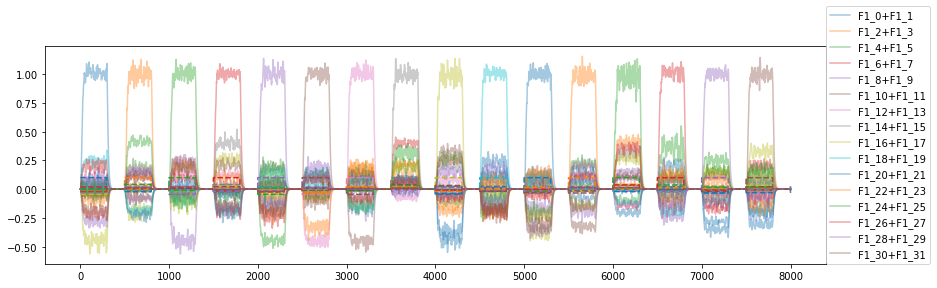

In [33]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(learned_sim.data[p_out][fan1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(learned_sim.data[p_cor][fan1_slc], fan1_pair_vecs)*0.1, linestyle="--")
plt.legend(fan1, loc=(1, 0))

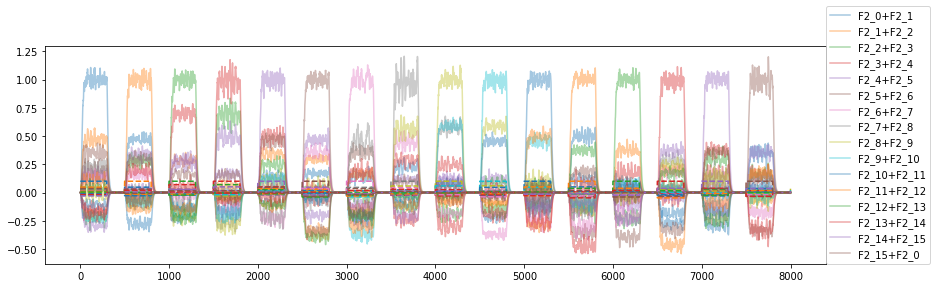

In [34]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(learned_sim.data[p_out][fan2_slc], fan2_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(learned_sim.data[p_cor][fan2_slc], fan2_pair_vecs)*0.1, linestyle="--")
plt.legend(fan2, loc=(1, 0))

In [35]:
dec = learned_sim.data[p_dec][-1]
dec.shape

(32, 500)

# Test

In [36]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

with nengo.Network(seed=seed) as test_model:
    in_nd = nengo.Node(feed.feed)
    correct = nengo.Node(feed.get_answer)
    pause = nengo.Node(lambda t: feed.paused)
    output = nengo.Node(size_in=dimensions)

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_weights, synapse=0.01)
    nengo.Connection(ens.neurons, output, transform=dec)

    p_in = nengo.Probe(in_nd)
    p_cor = nengo.Probe(correct, synapse=None)
    p_out = nengo.Probe(output, synapse=0.01)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(len(feed_vecs)*t_each + t_pause)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

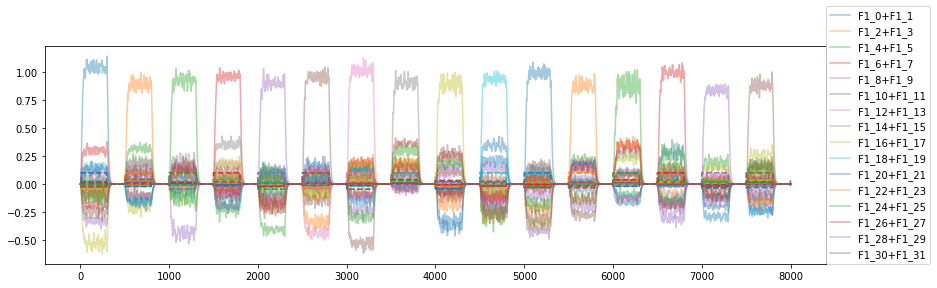

In [37]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan1_slc], fan1_pair_vecs)*0.1, linestyle="--")
plt.legend(fan1, loc=(1, 0))

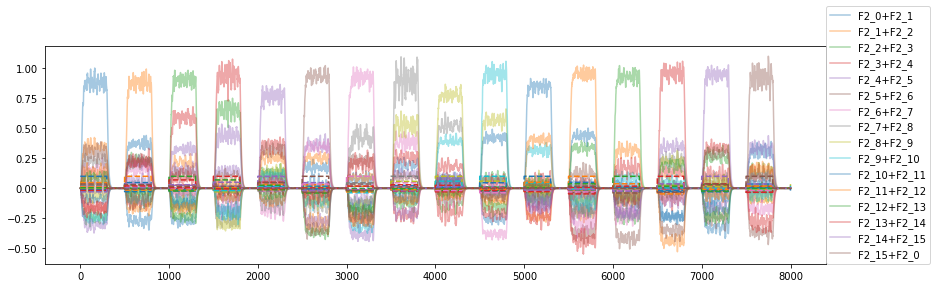

In [38]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][fan2_slc], fan2_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][fan2_slc], fan2_pair_vecs)*0.1, linestyle="--")
plt.legend(fan2, loc=(1, 0))

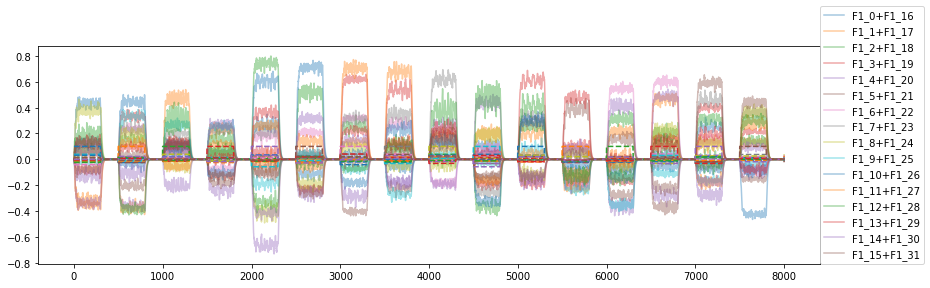

In [39]:
plt.figure(figsize=(14, 4))
plt.plot(spa.similarity(test_sim.data[p_out][foil1_slc], fan1_pair_vecs), alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(spa.similarity(test_sim.data[p_cor][foil1_slc], foil1_pair_vecs)*0.1, linestyle="--")
plt.legend(foil1, loc=(1, 0))

## Compare accuracy

Reaction times too, but only for targets.

In [40]:
def ans_acc(ans: np.ndarray, ans_vocab, num_items: int, td_item: int):
    ind_ans = spa.similarity(ans, ans_vocab).reshape((td_item, num_items, -1), order='F')
    tot_ans = np.sum(ind_ans, axis=0)
    res = np.argmax(tot_ans, axis=1)
    conf = np.max(tot_ans, axis=1)
    return res, conf

In [41]:
fan1_res, fan1_conf = ans_acc(test_sim.data[p_out][fan1_slc], all_fan_vecs, len(fan1), td_each)

In [42]:
print(fan1_res)
print(fan1_conf)
print(np.mean(fan1_conf))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[ 307.8541416   263.50012905  272.9450928   284.23649678  264.99786845
  281.44265784  299.46333036  267.48147077  262.62862993  276.44820691
  290.85065935  258.2352829   259.37454279  293.16693038  248.87871038
  256.27127123]
274.235963845


In [43]:
fan2_res, fan2_conf = ans_acc(test_sim.data[p_out][fan2_slc], all_fan_vecs, len(fan2), td_each)

In [44]:
print(fan2_res)
print(fan2_conf)
print(np.mean(fan2_conf))

[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]
[ 258.33921713  256.78617136  265.71591387  270.73908905  224.21527891
  277.05554175  268.74522052  260.89057708  229.09089122  279.77845731
  248.82810789  281.75577672  271.51597896  279.33177821  280.46025727
  267.98352093]
263.826986136


## Compare reaction times

I NO LONGER TRUST THIS CALCULATION.

In [45]:
def ans_conf(ans: np.ndarray, cor: np.ndarray, num_items: int, td_item: int):
    ind_ans = np.sum(ans*cor, axis=1).reshape((td_item, num_items, -1), order='F')
    conf = np.max(np.sum(ind_ans, axis=0), axis=1)
    return conf

In [46]:
ConfSlc = namedtuple("ConfSlc", ("ans_slc", "cor_slc", "n_items"))

In [47]:
confs = {}

for nm, obj in slc_stim_vecs.items():
    conf_res = ans_conf(
        test_sim.data[p_out][obj.slc],
        test_sim.data[p_cor][obj.slc],
        len(obj.vecs), td_each
    )
    confs[nm] = conf_res
    print(nm, np.mean(conf_res))

fan1 258.807613378
fan2 249.03020223
foil1 273.190691319
foil2 262.815993706


In [48]:
conf_df = pd.DataFrame(confs)

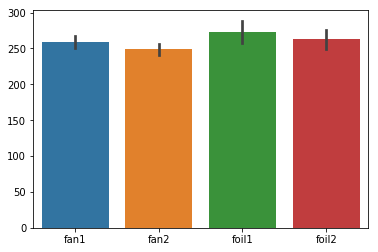

In [49]:
sns.barplot(data=conf_df)

Learning with recurrence works from decoding function 0, but never fully differentiating the foils. However, learning without recurrence does a worse job of seperating foils from targets. Learning from initial decoding works really poorly.